# Tutorial notebook for text classification with transformers-based models
Topic: Transformer architecture and contextual embeddings.

Lecturer: Salah Aït-Mokhtar

----



<br>





In this notebook, we will see how to use pre-trained transformer-based language models to assign contextual embeddings to texts, and also how to use them to solve a text classification task (sentiment analysis).

Outline:
* Downloading pre-trained, transformer-based language models from the HuggingFace (HF) repository.
* Tokenizing and encoding texts
* Computing contextual embeddings for tokens
* Global text representations from token embeddings
* Using transformer-based language model embeddings for text classification (sentiment analysis)


In [1]:
#!pip install transformers
#!pip install datasets
#!pip install evaluate
#!pip install pytorch-lightning


## Downloading pre-trained, transformer-based language models

The most popular repository of pre-trained language models is the [HuggingFace model repository](https://huggingface.co/models). Currently (2023/01/23), it contains about 122,264 models contributed by the NLP community around the world. Some of the models are monolingual, i.e. pre-trained (and sometimes fine-tuned) on monolingual data only. Others are multilingual. You can search the repository with keywords, and you can filter the list of models with the criteria on the left panel: by task type, language, python library compatibility (PyTorch, Tensorflow, etc.) or by license type. To access the description of a specific model, click on the selected model in the model list to access its card (description) page.

For the next steps of this notebook, we will use a BERT model, specifically the monolingual, case-sensitive [`bert-base-cased`](https://huggingface.co/bert-base-cased) version of BERT, pre-trained on English data (self-supervision with a masked language modeling objective).

To download the model, we need to provide the official name (identifier) of the model in the HF repository. You can find the exact name in the top-left corner of the model card page: it is the string followed by the copy-to-clipboard small icon.

Note that the model is downloaded only if there is no local copy that has been previously downloaded and cached on disk. When downloaded, the model is by default cached under the `.cache` subfolder in your home directory.

The code in the cell below shows how to download a model from the HF hub and get 3 model-related objects:
- the model configuration (`lmobject` in the code below) representing some important charcteristics of the model,
- the model tokenizer (`lmtokenizer`); and
- the language model itself (`lm`).

The warning you get is normal and due to the use of the generic class AutoModel (you can get rid of the warning, please read the comments in the code for more details):

In [1]:
import torch
from transformers import AutoConfig, AutoTokenizer, AutoModel, pipeline
from transformers import logging as hflogging


# HF name of the selected pre-trained language model (PLM):
plm_name = 'bert-base-cased'

# If you want to know the exact python class of the model, use the following 2 lines:
# obj = pipeline(model=plm_name)
# type(obj.model)

# But to download and instantiate the model, we will use the generic Auto* classes, so
# that we don't have to change the code when we select another model with a different
# transformer class.

# Load the config, the tokenizer and the model itself:
lmconfig = AutoConfig.from_pretrained(plm_name)
lmtokenizer = AutoTokenizer.from_pretrained(plm_name)
lm = AutoModel.from_pretrained(plm_name, output_attentions=False)

/home/noepeutot/miniforge3/envs/fouille_texte/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note that we load the model with the generic model class `AutoModel`. Since the original model class is different from AutoModel, the transformers library throws a warning, informing us of the model layers or components that were ignored when the model was loaded. In our case, it's a BERT model, pretrained with a masked-language modeling (MLM) objective, and therefore it has a prediction component to predict the masked tokens -- the warning says that the weights of that prediction component are discarded. That's fine, since we don't plan to train the model with an MLM objective: we just want to access its last hidden states, which are the contextual embeddings of the input text tokens. If such warnings bother you, you can supress them by setting the logging level to errors only, with the following line:

```python
hflogging.set_verbosity_error()
```

Now, let's examine some of the model characteristics through its configuration:

In [2]:
print("Model max input size:", lmconfig.max_position_embeddings)
print("Model embeddings size:", lmconfig.hidden_size)
print("Model number of hidden layers (encoder blocks):", lmconfig.num_hidden_layers)
print("Model vocab size:", lmconfig.vocab_size)

Model max input size: 512
Model embeddings size: 768
Model number of hidden layers (encoder blocks): 12
Model vocab size: 28996


## Tokenizing and encoding texts


We will now show how to transform input texts into vectors in order to feed them to the model. Let's consider the following list of (short) texts. As a side note: the word `bank` occurs in all the 4 texts, but with 2 different meanings: in the first 2 examples, it refers to a sloping land beside a body of water (`bank#1`). In the last 2 examples, it means a financial institution (`bank#2`).

In [3]:
# bank#1 (sloping land (especially the slope beside a body of water))
# bank#2 (a financial institution that accepts deposits and channels the money into lending activities)
texts = [
    "They pulled the canoe up on the bank",    # bank#1
    "He sat on the bank of the river and watched the currents",  # bank#1
    "He cashed a check at the bank",   # bank#2
    "That bank holds the mortgage on my home", # bank#2
]

For now, let's forget about meaning. We are going to tokenize the batch of texts with the model tokenizer and print the token sequences:

In [4]:
for text in texts:
    tokens = lmtokenizer.tokenize(text, add_special_tokens=True)
    print(tokens)

['[CLS]', 'They', 'pulled', 'the', 'canoe', 'up', 'on', 'the', 'bank', '[SEP]']
['[CLS]', 'He', 'sat', 'on', 'the', 'bank', 'of', 'the', 'river', 'and', 'watched', 'the', 'currents', '[SEP]']
['[CLS]', 'He', 'cash', '##ed', 'a', 'check', 'at', 'the', 'bank', '[SEP]']
['[CLS]', 'That', 'bank', 'holds', 'the', 'mortgage', 'on', 'my', 'home', '[SEP]']


Note that:
- Setting argument `add_special_tokens` to True automatically adds the model's special tokens to the tokenized texts: `[CLS]` marks the start of the text and `[SEP]` the end of the text.
- Tokenization yields tokens that generally correspond to English words (when they are part of the model's vocabulary). However, sometimes it produces subword tokens: in the example above, the word `cashed` is split into 2 tokens: `cash` and `##ed`.

Let's examine the model's vocabulary:


In [5]:
# get model's vocabulary (a dict mapping tokens to indices)
vocab = lmtokenizer.get_vocab()
# What's the size of the vocab?
print("Vocab size:", len(vocab))
# is the word "cashed" in the vocab? (False!)
print("'cashed' in the vocab?", "cashed" in vocab)
# is the word "cash" in the vocab? (True!)
print("'cash' in the vocab?", "cash" in vocab)

Vocab size: 28996
'cashed' in the vocab? False
'cash' in the vocab? True


In [6]:
# Reverse the vocab so that we can access tokens from their indices:
idx2token = {idx: token for (token, idx) in vocab.items()}
# Token at index 0 is the [PAD] symbol
print("==> At index 0:", idx2token[0])
# Tokens from index 1 to 100 not used
print("==> At index 99:", idx2token[99])
# First tokens from index 100 up are mostly special symbols and single characters
print("==> Indices 100 to 150:", [idx2token[idx] for idx in range(100,150)])
# First english word seems to be "the" and is at index 1103:
print("==> Indices 1100 to 1200:", [idx2token[idx] for idx in range(1100, 1200)])

==> At index 0: [PAD]
==> At index 99: [unused99]
==> Indices 100 to 150: ['[UNK]', '[CLS]', '[SEP]', '[MASK]', '[unused100]', '[unused101]', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
==> Indices 1100 to 1200: ['－', '／', '：', 'the', 'of', 'and', 'to', 'in', 'was', 'The', 'is', 'for', 'as', 'on', 'with', 'that', '##s', 'his', 'by', 'he', 'at', 'from', 'it', 'her', 'He', 'had', 'an', 'were', 'you', 'be', 'In', 'she', 'are', 'but', 'which', 'It', 'not', 'or', 'have', 'my', 'him', 'one', 'this', 'me', 'has', 'also', 'up', 'their', 'first', 'out', 'who', 'been', 'they', 'She', 'into', 'all', 'would', 'its', '##ing', 'time', 'two', '##a', '##e', 'said', 'about', 'when', 'over', 'more', 'other', 'can', 'after', 'back', 'them', 'then', '##ed', 'there', 'like', 'so', 'only', '##n', 'could', '##d', '##i', '##y', 'what', 

Back to tokenizing and encoding texts.

Method tokenize() seen above produces sequences of tokens, but if we want to feed the texts to a neural network, we need to transform those tokens into numerical values.

The first component in a transformer-based model is the embedding layer: the row indices of its embedding matrix correspond to the token indices in the model vocabulary. The embedding layer takes token indices as input, and produces token embedding vectors by selecting the corresponding rows in the embedding matrix. This means that tokenizing input texts is not enough: we need to transform the input tokens into token indices, before feeding them to the model.

Hence, encoding texts for the model requires tokenizing them **and** mapping the resulting tokens to their indices.

The model tokenizer (`lmtokenizer` in our code) does exactly that: it tokenizes a batch of texts, and returns a BatchEncoding object (a dict) that has the `input_ids` key, the value of which contains a sequence of token indices for each of the input texts:

In [7]:
from pprint import pprint

encoded_texts = lmtokenizer(texts,
    truncation=True,
    add_special_tokens=True,
    padding=False,
    return_tensors=None,
    return_attention_mask=False,
    return_offsets_mapping=False,
    return_token_type_ids=False,
)

pprint(encoded_texts, width=150)

{'input_ids': [[101, 1220, 1865, 1103, 21291, 1146, 1113, 1103, 3085, 102],
               [101, 1124, 2068, 1113, 1103, 3085, 1104, 1103, 2186, 1105, 2542, 1103, 16334, 102],
               [101, 1124, 5948, 1174, 170, 4031, 1120, 1103, 3085, 102],
               [101, 1337, 3085, 3486, 1103, 16935, 1113, 1139, 1313, 102]]}


With the `truncation` argument set to True, we ensure that token sequences longer than the model max input size are truncated.

Note that the output above is a list of (non-equal-length) lists, not tensors. If we want to get (PyTorch) tensors that can be directly fed to the model, we set argument `return_tensors` to `'pt'` and argument `padding` to `True`, so that for every text batch, the `input_ids` value is a matrix of shape `(N, max_len)`, where `N` is the number of texts in the batch, and `max_len` is the longest token sequence in the batch. Token sequences shorter than `max_len` are padded on the right with the special token `[PAD]` (whose id is `0` in this model) so that all texts in the batch end up with the same length. We also set argument `return_attention_mask` to True in order to get the attention mask vectors: these contain value 1 in the positions corresponding to real tokens in the original texts, and value 0 in all padded positions. Attention masks come handy for all situations where we want to exclude padding tokens, e.g.:
- When computing the contextual embeddings of the (real) tokens, since the padding tokens do not contribute to the meaning of real tokens.
- When fine-tuning a model for a text classification task, like sentiment analysis, we need to compute a global vector representation for a text from its tokens embeddings. This process is often called _pooling_, and the resulting text vector is fed to a classifier component (usually a linear or a 2-layer feed-forward network followed by a sigmoid or softmax). In that case, we might want to exclude the padding tokens from the pooling since they don't contribute to the meaning of the text.
- When fine-tuning a model on token-level classification tasks, such as Named Entity Recognition (NER) or slot filling in Natural Language Understanding (NLU), attention masks make it possible to exclude padding tokens during the computation of the mean loss of a batch.


In [8]:
encoded_texts = lmtokenizer(texts,
    truncation=True,
    add_special_tokens=False,
    padding=True,
    return_tensors='pt',
    return_attention_mask=True,
    return_offsets_mapping=False,
    return_token_type_ids=False,
)

encoded_texts

{'input_ids': tensor([[ 1220,  1865,  1103, 21291,  1146,  1113,  1103,  3085,     0,     0,
             0,     0],
        [ 1124,  2068,  1113,  1103,  3085,  1104,  1103,  2186,  1105,  2542,
          1103, 16334],
        [ 1124,  5948,  1174,   170,  4031,  1120,  1103,  3085,     0,     0,
             0,     0],
        [ 1337,  3085,  3486,  1103, 16935,  1113,  1139,  1313,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])}

With the `input_ids` and the `attention_mask` values, we have the minimal input information generally required for transformer-based language models.  


## Computing contextual embeddings for tokens



In [9]:
# Put the model in inference mode
lm.eval()

# Feed the encoded texts (`input_ids` and `attention_mask`) into the language model
with torch.no_grad():
    output = lm(**encoded_texts)
    # Above call can be replaced with:
    # output = lm(input_ids=encoded_texts['input_ids'], attention_mask=encoded_texts['attention_mask'])
    # retrieve the hidden states of the last encoder layer: these are
    # the contextual embeddings of the input text tokens
    token_embeddings = output.last_hidden_state

token_embeddings.shape

torch.Size([4, 12, 768])

As expected, the output embedding tensor `token_embeddings` has shape `(N, max_len, emb_dim)`, with `N` being the number of texts in the batch (4 in our batch example), `max_len` is the length of the longest text in the batch, and `emb_dim` is the size of the model embedding vectors (768 in the BERT model we're using). We can access the embeddings of the j_th word of the i_th text with `token_embeddings[i, j]`.

Let's check if the embeddings produced by the model are really contextual, i.e. the similarity of the embeddings of a given word occurring in distinct sentences should be higher when the contexts in the sentences are similar, and lower when the contexts are dissimilar. We will look at the embeddings of the word `bank` in the 4 texts provided above in this notebook (variable `texts`). We use cosine similarity as a similarity score.

In [10]:
from torch.nn import functional as F

tokenized_texts = [ lmtokenizer.tokenize(text) for text in texts]

def sim_info(text_idx1, token_idx1, text_idx2, token_idx2, texts, token_embeddings):
    s = F.cosine_similarity(token_embeddings[text_idx1,token_idx1], token_embeddings[text_idx2, token_idx2], dim=0)
    w1 = tokenized_texts[text_idx1][token_idx1]
    w2 = tokenized_texts[text_idx2][token_idx2]
    return f"- {texts[text_idx1]}\n- {texts[text_idx2]}\nsim({w1},{w2})={round(s.item(),4)}\n"

print(sim_info(0, 7, 1, 4, texts, token_embeddings))
print(sim_info(0, 7, 2, 7, texts, token_embeddings))
print(sim_info(0, 7, 3, 1, texts, token_embeddings))
print(sim_info(1, 4, 2, 7, texts, token_embeddings))
print(sim_info(1, 4, 3, 1, texts, token_embeddings))
print(sim_info(2, 7, 3, 1, texts, token_embeddings))

- They pulled the canoe up on the bank
- He sat on the bank of the river and watched the currents
sim(bank,bank)=0.7486

- They pulled the canoe up on the bank
- He cashed a check at the bank
sim(bank,bank)=0.6874

- They pulled the canoe up on the bank
- That bank holds the mortgage on my home
sim(bank,bank)=0.6448

- He sat on the bank of the river and watched the currents
- He cashed a check at the bank
sim(bank,bank)=0.6502

- He sat on the bank of the river and watched the currents
- That bank holds the mortgage on my home
sim(bank,bank)=0.635

- He cashed a check at the bank
- That bank holds the mortgage on my home
sim(bank,bank)=0.732



We can see that the similarity of the embeddings of `bank` is higher when used in a similar context and has the same meaning (either 'sloping land' or 'financial institution').

## Global text representation vector

A simple way to get global text vectors is to take the mean or the max token embeddings along dimension 1 of the tensor, i.e. the time dimension of the token sequences:

In [11]:
global_embedings = token_embeddings.mean(dim=1)
print("First 5 values in each text vector:")
for text, vect in zip(texts, global_embedings):
    print(vect[:5], text)
global_embedings.shape

First 5 values in each text vector:
tensor([-0.0482, -0.0564, -0.1147,  0.2194,  0.3447]) They pulled the canoe up on the bank
tensor([-0.5213, -0.3902, -0.2681,  0.3019,  0.4678]) He sat on the bank of the river and watched the currents
tensor([-0.0353, -0.3801,  0.0774,  0.6090,  0.3787]) He cashed a check at the bank
tensor([-0.4288, -0.4159, -0.0042, -0.0211,  0.0831]) That bank holds the mortgage on my home


torch.Size([4, 768])

And that's it: we obtained 4 vectors in the embedding space, one for each of the 4 texts.

However, with mean() or max() standard methods, padding tokens are included in the computation of the text embeddings, which is not ideal because they do not contribute to the meaning of texts. How can we excldude them from the text representations? We have to write a more sophisticated mean or max pooling method, leveraging the attention mask, the values of which, as you know, indicate which positions in the token sequences contain real versus padding tokens. Here is an example of such mean/max pooling that excludes padding tokens (read the comments in the code for detailed explanations):

In [12]:
# computing embedding vector for a whole text from the embeddings of its tokens, excluding
# the padding tokens. The token_embeddings argument is a tensor (N, seq_len, emb_dim)
# containing the token embeddings of the texts in a batch; and attention_mask is
# a tensor (N, seq_len) containing the attention mask values for the token sequences.


# Method 1: mean pooling that discards padding tokens
def pool_mean_embeddings(token_embeddings, attention_mask):
    # we reshape the mask to add a 3rd dimension (corresponding to the embedding dim) and
    # we expand it by duplicating its binary values along that dimension. We obtain
    # a (N, seq_len, emb_dim) tensor (similar to the token embeddings shape)
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    # we multiply the token embeddings and the expanded mask (element-wise) to set
    # to zero all the embedding values corresponding to padding positions; and then
    # we sum the modified embeddings along dim 1 (time dimension of the token sequences).
    # padding positions are excluded from this sum because their values were set to
    # zero by the element-wise multiplication with the expanded mask.
    # resulting shape = (N, emb_dim)
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
    # we also sum the expanded mask values along the time dimension: we obtain counts
    # of non-padding tokens for each sequence in the batch, shape=(N, emb_dim)
    sum_mask = input_mask_expanded.sum(dim=1)
    # we will divide the sum_embeddings by the sum_mask (aka. counts of non padding tokens)
    # to get the mean embeddings. In order to avoid division by zero (which might happen,
    # in theory, when there is an empty token sequence that contains only padding
    # tokens), we first clamp the sum_mask with a very small non-zero value
    sum_mask = torch.clamp(sum_mask, min=1e-9)
    # divide the sum_embeddings by the sum_mask to get the mean embeddings
    mean_embeddings = sum_embeddings / sum_mask
    # shape = (N, emb_dim)
    return mean_embeddings


# Method 2: max pooling that ignores padding positions
def pool_max_embeddings(token_embeddings, attention_mask):
    # assign a very large value to all padding positions in the mask, and assign 0 otherwise
    # and then expand the mask, duplicating the values along an additional 3rd dim
    # resulting shape: (N, seq_len, emb_dim)
    input_mask_expanded = torch.where(attention_mask==0, 1e9, 0.).unsqueeze(-1).expand(token_embeddings.size()).float()
    # substract the modified mask values from the token embeddings and take the max
    # along the time dim. Since padding positions have very large values, the
    # corresponding positions in the substraction result will be very small (large
    # negative values) and hence will be discarded by the max function
    maxpooled_embeddings = torch.max(token_embeddings-input_mask_expanded, dim=1)[0]
    return maxpooled_embeddings


global_embedings = pool_mean_embeddings(token_embeddings, encoded_texts['attention_mask'])

print("First 5 values in each text vector:")
for text, vect in zip(texts, global_embedings):
    print(vect[:5], text)

First 5 values in each text vector:
tensor([-0.0697, -0.0757, -0.0965,  0.2245,  0.3570]) They pulled the canoe up on the bank
tensor([-0.5213, -0.3902, -0.2681,  0.3019,  0.4678]) He sat on the bank of the river and watched the currents
tensor([-0.0322, -0.2638,  0.1884,  0.5963,  0.3906]) He cashed a check at the bank
tensor([-0.4982, -0.3542, -0.0129, -0.0154,  0.1286]) That bank holds the mortgage on my home


Note that this way of pooling the mean or max of exclusively non-padding token embeddings is compatible with backpropagation and hence can be used to fine-tune the model on tasks requiring global text representations.

There are other methods for computing text vectors from their token embeddings. We could use 1D convolutional layers for instance, or even an LSTM or a BiLSTM. But for the purpose of this notebook, we will stick to mean or max pooling.

Since we can compute and assign a vector representation to a whole text based on its token embeddings, it is relatively easy to build a model for any text classification task: just add a classification head component on top of the global embeddings pooler. The classification component is generally a linear layer or a 2-layer feed-forward network, plus a sigmoid or softmax depending on the type of classification (binary classification versus multi-class classification, single-label versus multi-label multi-class classification).

In the remaining of this notebook, we will solve the sentiment analysis task introduced in the Lecture #2 notebook using a transformer-based language model.

----
## Text classification for sentiment analysis using transformer-based language models

We will work with the `imdb` sentiment analysis dataset that you have already seen in the code examples provided in Lecture #2. See [IMDB](https://ai.stanford.edu/~amaas/data/sentiment/).

In the dataset, reviews are labeled with 2 possible classes: positive and negative. Hence the task in hand is a binary classification task.



#### Defining the classification model

Our classification model will be relatively simple: the BERT pre-trained model is augmented with a pooling layer that computes global text vectors from the token embeddings (see previous section), and a linear classifier head:

In [13]:
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np


class TransformerBinaryClassifier(torch.nn.Module):

    def __init__(self, plm_name: str):
        super(TransformerBinaryClassifier, self).__init__()
        self.lmconfig = AutoConfig.from_pretrained(plm_name)
        self.lmtokenizer = AutoTokenizer.from_pretrained(plm_name)
        self.lm = AutoModel.from_pretrained(plm_name, output_attentions=False)
        self.emb_dim = self.lmconfig.hidden_size
        self.output_size = 1
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.2),
            torch.nn.Linear(self.emb_dim, self.output_size),
            torch.nn.Sigmoid()
        )
        self.loss_fn = torch.nn.BCELoss(reduction='mean')


    def forward(self, x):
        x : torch.Tensor = self.lm(x['input_ids'], x['attention_mask']).last_hidden_state
        global_vects = x.mean(dim=1)
        x = self.classifier(global_vects)
        return x.squeeze(-1)

    def compute_loss(self, predictions, target):
        return self.loss_fn(predictions, target)


model = TransformerBinaryClassifier(plm_name)


#### Downloading the dataset

This `imdb` dataset, like many others, is available on the [HuggingFace (HF) dataset hub](https://huggingface.co/datasets). You can find its card [here](https://huggingface.co/datasets/imdb).

In order to download the dataset from the HF hub, we use the HF `datasets` python module.

Downloading the `train` and `test` splits of the dataset:

In [14]:
import datasets

ds_train = datasets.load_dataset("imdb", split='train')
ds_test = datasets.load_dataset("imdb", split='test')

# df_train.reset_index(drop=True, inplace=True)

Let's have a look at some random examples from the train split:

In [15]:
import pandas as pd
pd.options.display.max_colwidth=120

df_train = ds_train.shuffle().to_pandas()
df_train.head()

,text,label
0,"Deliverance is the fascinating, haunting and sometimes even disturbing tale by James Dickey, turned into a brilliant...",1
1,I may not be the one to review this movie because after 45 minutes of pure boredom and stupidity I turned the channe...,0
2,In a word...amazing.<br /><br />I initially was not too keen to watch Pinjar since I thought this would be another m...,1
3,"*I mark where there are spoilers! Overall comments: If you can take a serious movie, go see this. Have an open mind ...",1
4,"One woman, by herself in a house for 45-minutes of screen time, doesn't sound like a formula to hold you on the edge...",1


#### Tokenization

We tokenize the texts and encode them with the tokenizer of the pre-trained language model. Remember: the tokenizer produces a dict with `input_ids` and `attention_mask` tensors (see the first part of this notebook). There are examples in the datasets that are longer than the model max input length (which is 512 in the BERT model we are using), so we set argument `truncation` to True:

In [17]:

X_train_encoded = model.lmtokenizer(list(ds_train["text"]),
                            truncation=True,
                            padding=False,
                            add_special_tokens=False,
                            return_tensors=None,
                            return_offsets_mapping=False,
                        )

X_test_encoded = model.lmtokenizer(list(ds_test["text"]),
                            truncation=True,
                            padding=False,
                            add_special_tokens=False,
                            return_tensors=None,
                            return_offsets_mapping=False,
                        )

Let's see the distribution of lengths in the resulting (truncated) encoded sequences:

In [18]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Number of sequences')

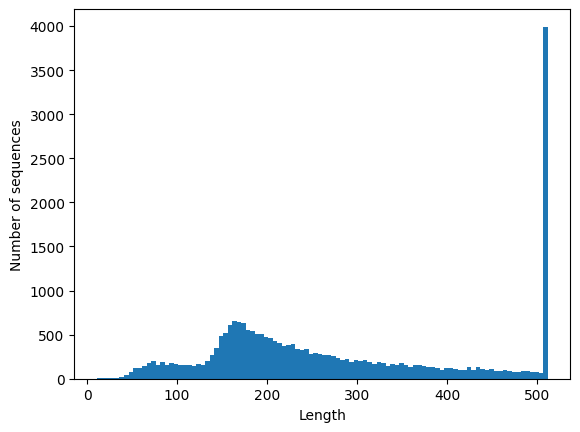

In [19]:
_ = plt.hist([len(text_ids) for text_ids in X_train_encoded['input_ids']], 100)
plt.xlabel("Length")
plt.ylabel("Number of sequences")

We can see that a fair amount of examples were truncated to fit in the max input size (let's call it `max_input_len`) of the model (about 4000, among the 25000 training examples). On the other hand, many examples are significantly shorter than that.

You know from NLP Lecture #2 that it is necessary to pad input sequences in a batch to ensure they all have the same length when the batch is fed into a neural model.

There are various padding strategies, each with pros and cons:

- Static (global) padding: padding all the examples at once, before starting training. Pros: each example is padded only once, for all the training epochs. Cons: ids and mask vectors have the max length (`max_input_len`) for all texts, including the many ones that are significantly shorter. This maximizes the number of padding positions, and hence results in a waste of memory and computation power.

- Dynamic (batch-wise) padding: the examples are padded during training, within every batch, to fit the longest example in the batch. Pros: shorter examples will not be padded to `max_input_len` if the longest example in the same batch is shorter than `max_input_len` (hence less waste of memory and computation power than in global padding). Cons: each example will be padded multiple times during training since the padding depends on the longest example in the batch.

- Similar-length batching (with dynamic padding): when building the batches, we ensure that examples grouped in the same batch have similar or comparable lengths. Pros: minimizes padding and therefore speeds up training. Cons: this strategy partially breaks the randomness of the order of training examples, which introduces a bias in the learning process and may sometimes decrease the classifier accuracy.

Since our goal here is not to optimize computation, we will just follow the default strategy used in the Trainer object of the transformers library, which is batch-wise dynamic padding.


We will take a small subset of the dataset (1000 both for train/test) just to be able to test quickly the remaning parts of this notebook, especially the  training code. Remove this selection if you want to train with the whole dataset splits:

In [21]:
# Testing with smaller datasets
ds_train = ds_train.shuffle(seed=42).select(range(1000))
ds_test = ds_test.shuffle(seed=42).select(range(1000))

Let's tokenize and encode the train and test texts. The encodings are added as new columns to the HF dataset objects. We also remove column 'text' (not needed anymore) and change the column name 'label' to 'labels'. Note that the texts are truncated to the max input length accepted by the model, but they are not padded because we will be using dynamic (batch-wise) padding:

In [22]:
def tokenize_function(examples):
    return model.lmtokenizer(examples["text"], truncation=True)


# ds_train = ds_train.rename_column("label", "labels")
# ds_test = ds_test.rename_column("label", "labels")

# tokenize datasets
tok_ds_train = ds_train.map(tokenize_function, batched=True)
tok_ds_test = ds_test.map(tokenize_function, batched=True)

tok_ds_train = tok_ds_train.remove_columns(["text"])
tok_ds_test = tok_ds_test.remove_columns(["text"])

tok_ds_train = tok_ds_train.rename_column("label", "labels")
tok_ds_test = tok_ds_test.rename_column("label", "labels")

Map: 100%|█████████████████████████| 1000/1000 [00:00<00:00, 5206.48 examples/s]


Let's check the (new) structure of the dataset objects. You can see that the encoding information has been added as columns:

In [22]:

tok_ds_train

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

Now we will create the data loaders for the train and test sets. As a collate function (i.e. the function used by a data loader to build batches from instances sampled from a dataset), we use the `DataCollatorWithPadding` class from the `transformers`library. It automatically performs dynamic (batch-wise) padding. It can do this because it recognizes the relevant "keys" that encode the input texts, i.e. the dataset column names `input_ids` and `attention_mask`:

In [23]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

data_collator = DataCollatorWithPadding(tokenizer=model.lmtokenizer, padding=True, return_tensors='pt')

train_dataloader = DataLoader(tok_ds_train, shuffle=True, batch_size=8, collate_fn=data_collator)
eval_dataloader = DataLoader(tok_ds_test, batch_size=8, collate_fn=data_collator)

# just for testing
for b in train_dataloader:
    print(b)
    break

{'labels': tensor([0, 1, 1, 0, 0, 1, 0, 0]), 'input_ids': tensor([[  101,  1966,   146,  ...,     0,     0,     0],
        [  101,  1135,  1110,  ...,     0,     0,     0],
        [  101,   146,  1538,  ...,     0,     0,     0],
        ...,
        [  101,   107,  2409,  ...,   135,  2543,   102],
        [  101, 12082,  1116,  ...,     0,     0,     0],
        [  101,  1142,  2523,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


For training, we define an optimizer, a learning rate scheduler and we put the model in the gpu:

In [24]:
from torch.optim import AdamW
from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)


num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# device = 'cpu'

model.to(device)

lr_scheduler

Training the model:

In [25]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        predictions = model(batch)
        loss = model.loss_fn(predictions, batch['labels'].float())
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)



  0%|          | 0/375 [00:00<?, ?it/s]

We define a prediction method that applies the model on a list of texts, gets the probability outputs, converts them to labels ("positive" and "negative") and returns tuples of `(text, predicted_label)`:

In [26]:

def predict(model, texts):
  model.eval()
  encoded_texts = model.lmtokenizer(texts, truncation=True, padding=True, return_attention_mask=True, return_tensors='pt')
  with torch.no_grad():
    output = model(encoded_texts.to(device)).tolist()
    pred_labels = ["positive" if p>0.5 else "negative" for p in output]
    return list(zip(texts, pred_labels))


We use the prediction method to label a couple of texts:

In [27]:
texts = [
    "That was a horrible movie!",
    "I really liked it! Nice acting.",
]

predict(model, texts)

[('That was a horrible movie!', 'negative'),
 ('I really liked it! Nice acting.', 'positive')]


With all this, you have all that's needed to be able to download transformer-based, pre-trained language models (PLMs) and take advantage of their contextual embeddings to build classifiers.

------------------------



# Exercise

(it's completely optional and suggested for students who want to try models themselves, it's not rated and does not affect final marks. But it helps better understand the lecture and you can ask questions in the google group!)

- Add code to print mean loss at the end of every epoch, during training
- Add code to evaluate the fine-tuned model on the test split
- Add code for **early stopping**, with the selection of the best model checkpoint.
- In the model, change the pooling from the standard mean() function to the provided average and/or max pooling that discards paddings. Retrain the model and see if that improves performance.
- Combine both average and max pooling vectors (concatenate them) and see if that helps.
- Train the model on the full train split (adapt batch size and learning rate accordingly) and evaluate it on the full test split.

